In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.api as sm 
import statsmodels.formula.api as smf

from sklearn import linear_model
from sklearn.feature_selection import RFE
import plotly.express as px

## IMPORT DATASET AND CREATE MORE USEFUL COLUMNS

In [2]:
df = pd.read_csv("capstone_2014&2019.csv")

In [3]:
## here I am making several column adjustments to get more useful information to work with 

In [4]:
## add existing users of public healthcare with those without healthcare to get the total target number 
df["need_coverage"] = df["2019_total_no_coverage"] + df["2019_total_w_pbcoverage"] 

In [5]:
## convert the target into a percentage of the total population 
df["percentage_need_coverage"] = df["need_coverage"] / df["2019_total_pop"]

In [6]:
## remove columns that have been added to create the target variables
df.drop(['2019_total_no_coverage','2019_total_w_pbcoverage','2019_total_pop'],axis=1,inplace=True)

In [7]:
## do the same with the input year data, it might help with predictions in a linear model 
df["2014_need_coverage"] = df["total_no_coverage"] + df["total_w_pbcoverage"]
df["2014%need_coverage"] = df["2014_need_coverage"] / df["total_pop"]

In [8]:
## rename columns so that they can be properly used in an OLS regression 
## this was done after a recursive factor elimination chose these as good predictors 
## this step ended up being irrelevant as no OLS was ever more accurate than 50% 

df.rename(columns = {'Total_16&Over':"total_sixteen_yrs_plus",
                     '25-44years':"twentyfive_to_fortyfour_yrs", 
                     '45-64years':"fortyfive_to_sixtyfour_yrs", 
                     '65+years':"sixtyfive_yrs_plus",},inplace=True)

In [9]:
## Variables to change to percentage of overall population 
## These are mostly variables that were found using RFE

df["percentage_Employed"] = df["Employed"] / df["total_pop"]
df["percentage_Unemployed"] = df["Unemployed"] / df["total_pop"]
df["percentage_fortyfive_to_sixtyfour_yrs"] = df["fortyfive_to_sixtyfour_yrs"] / df["total_pop"]
df["percentage_households_not_receiving_benefits"] = df["households_not_receiving_benefits"] / df["total_pop"]

df["percentage_sixtyfive_yrs_plus"] = df["sixtyfive_yrs_plus"] / df["total_pop"]
df["percentage_no_coverage"] = df["total_no_coverage"] / df["total_pop"]
df["percentage_female"] = df["total_pop_female"] / df["total_pop"]
df["percentage_male"] = df["total_pop_male"] / df["total_pop"]

df["percentage_sixteen_yrs_plus"] = df["total_sixteen_yrs_plus"] / df["total_pop"]
df["percentage_w_pbcoverage"] = df["total_w_pbcoverage"] / df["total_pop"]
df["percentage_twentyfive_to_fortyfour_yrs"] = df["twentyfive_to_fortyfour_yrs"] / df["total_pop"]

## make these percentages as well, to continue testing my hypothesis 

df["percentage_Grade_School"] = df["Grade_School"] / df["total_pop"]
df["percentage_HS_Diploma_GED"] = df["HS_Diploma_GED"] / df["total_pop"]
df["percentage_Higher_Ed"] = df["Higher_Ed"] / df["total_pop"]

In [10]:
## see if I can separate counties by size in any meaningful way 

print("Largest county population = " + str(df["total_pop"].max()))
print("Smallest county population = " + str(df["total_pop"].min()))
print("Average county population = " + str(round(df["total_pop"].mean())))

print("Counties with pop under 15K = " + str(df[df["total_pop"] < 15000].county_index.count()))
print("Counties with pop between 15K & 36K = " + str(df[(df["total_pop"] > 15000) & (df["total_pop"] < 36000)].county_index.count()))
print("Counties with pop over 36K = " + str(df[df["total_pop"] > 36000].county_index.count()))

Largest county population = 1184091
Smallest county population = 3455
Average county population = 61881
Counties with pop under 15K = 30
Counties with pop between 15K & 36K = 28
Counties with pop over 36K = 29


In [11]:
## separate counties by population size into a categorical value column 
## 1 = small 
## 2 = medium 
## 3 = large 

df["county_size"] = 0 
df.loc[df["total_pop"]<=15000,"county_size"]=1
df.loc[(df["total_pop"]>15000)&(df["total_pop"]<36000),"county_size"]=2
df.loc[df["total_pop"]>=36000,"county_size"]=3

In [12]:
## see if I can separate the "need_coverage2014" column into meaningful categorical data 

print("Minimum percentage of a county population needing public healthcare: " + str((round(df["2014%need_coverage"].min(),3))*100) + "%")
print("Maximum percentage of a county population needing public healthcare: " + str((round(df["2014%need_coverage"].max(),3))*100) + "%")
print("Average percentage of a county population needing public healthcare: " + str((round(df["2014%need_coverage"].mean(),3))*100) + "%")

print("High need counties: " + str(df[df["2014%need_coverage"] > .408].county_index.count()) + " (over the average)")
print("Low need counties: " + str(df[df["2014%need_coverage"] < .408].county_index.count()) + " (under the average)")

Minimum percentage of a county population needing public healthcare: 20.5%
Maximum percentage of a county population needing public healthcare: 64.2%
Average percentage of a county population needing public healthcare: 40.8%
High need counties: 47 (over the average)
Low need counties: 40 (under the average)


In [13]:
## separate counties by public healthcare needs into a categorical value column 
## 1 = county's public healthcare needs exceed the average 
## 0 = county's public healthcare needs are below the average 

df["high_need_counties"] = df["2014%need_coverage"].apply(lambda x: 1 if x > .408 else 0)

In [57]:
## Quick manual look at educational attainment averages 

print(df["percentage_Higher_Ed"].min())
print(df["percentage_Higher_Ed"].max())
print(df["percentage_Higher_Ed"].mean())

print(df["percentage_HS_Diploma_GED"].min())
print(df["percentage_HS_Diploma_GED"].max())
print(df["percentage_HS_Diploma_GED"].mean())

print(df["percentage_Grade_School"].min())
print(df["percentage_Grade_School"].max())
print(df["percentage_Grade_School"].mean())

0.2889172438935472
0.5578218202809313
0.38622616880175287
0.12404620928627952
0.31715291750503016
0.2343557827974874
0.02687390159072195
0.13539302422529992
0.06366525094153014


In [15]:
## create a value to measure graduation rates, this will be used to evaluate parts of the hypothesis 

df["percentage_HS_and_Higher"] = df["percentage_HS_Diploma_GED"] + df["percentage_Higher_Ed"]

In [16]:
## use average graduation rates as a basis to create a binary categorical variable about educational attainment 

print("Minimum percentage of High School level Educational Attainment: " + str((round(df["percentage_HS_and_Higher"].min(),3))*100) + "%")
print("Maximum percentage of High School level Educational Attainment: " + str((round(df["percentage_HS_and_Higher"].max(),3))*100) + "%")
print("Average percentage of High School level Educational Attainment: " + str((round(df["percentage_HS_and_Higher"].mean(),3))*100) + "%")

print("Higher HS Graduation Rates: " + str(df[df["percentage_HS_and_Higher"] > .621].county_index.count()) + " (over the average)")
print("Lower HS Graduation Rates: " + str(df[df["percentage_HS_and_Higher"] < .621].county_index.count()) + " (under the average)")

Minimum percentage of High School level Educational Attainment: 51.0%
Maximum percentage of High School level Educational Attainment: 75.2%
Average percentage of High School level Educational Attainment: 62.1%
Higher HS Graduation Rates: 47 (over the average)
Lower HS Graduation Rates: 40 (under the average)


In [17]:
## separate counties by graduation rates
## 1 = above average HS graduation rates 
## 0 = below average HS graduation rates 

df["above_av_grad_rates"] = df["percentage_HS_and_Higher"].apply(lambda x: 1 if x > .621 else 0)

In [20]:
## see if I can separate the "need_coverage" (2019) column into meaningful categorical data 

print("Minimum percentage of a county population needing public healthcare in 2019: " + str((round(df["percentage_need_coverage"].min(),3))*100) + "%")
print("Maximum percentage of a county population needing public healthcare in 2019: " + str((round(df["percentage_need_coverage"].max(),3))*100) + "%")
print("Average percentage of a county population needing public healthcare in 2019: " + str((round(df["percentage_need_coverage"].mean(),3))*100) + "%")

print("2019 High need counties: " + str(df[df["percentage_need_coverage"] > .426].county_index.count()) + " (over the average)")
print("2019 Low need counties: " + str(df[df["percentage_need_coverage"] < .426].county_index.count()) + " (under the average)")

Minimum percentage of a county population needing public healthcare in 2019: 23.1%
Maximum percentage of a county population needing public healthcare in 2019: 70.5%
Average percentage of a county population needing public healthcare in 2019: 42.6%
2019 High need counties: 44 (over the average)
2019 Low need counties: 43 (under the average)


In [21]:
## separate counties by 2019 public healthcare needs into a categorical value column 
## 1 = county's public healthcare needs exceed the average (high-need)
## 0 = county's public healthcare needs are below the average (low-need)

df["2019_high_need_counties"] = df["percentage_need_coverage"].apply(lambda x: 1 if x > .426 else 0)

In [23]:
## Now rearrange the columns so they are easy to find and work with 

df = df[['county_index', 
         'need_coverage', ## variable from the target year 
         'percentage_need_coverage', ## linear target variable 
         '2019_high_need_counties', ## logistic target variable        
         
         'percentage_no_coverage', 
         'percentage_Employed',
         'percentage_Unemployed', 
         'percentage_female', 
         'percentage_male', 
         'percentage_sixteen_yrs_plus',
         'percentage_twentyfive_to_fortyfour_yrs',
         'percentage_fortyfive_to_sixtyfour_yrs',
         'percentage_sixtyfive_yrs_plus', 
         'percentage_w_pbcoverage', 
         'percentage_households_not_receiving_benefits', ## good predictor variables converted to percentages 
         
         'percentage_Grade_School', 
         'percentage_HS_Diploma_GED',
         'percentage_Higher_Ed', 
         'percentage_HS_and_Higher', ## education variables converted to percentages to continue testing my hypothesis 

         'county_size', 
         'above_av_grad_rates', ## generated categorical variable that I think will be usefull in visualizations 
         'high_need_counties', ## logistic target variable, but from 2014 instead of 2019 
                  
         '2014%need_coverage', 
         '2014_need_coverage', ## linear target variables, but from 2014 instead of 2019 
         
         'total_pop', 
         'total_pop_male', 
         'total_pop_female',
         'median_age_all', 
         'median_age_male', 
         'median_age_female', 
         '0-17years',
         '18-24years', 
         'twentyfive_to_fortyfour_yrs', 
         'fortyfive_to_sixtyfour_yrs', 
         'sixtyfive_yrs_plus', ## population and age breakdowns 
         
         'Employed',
         'Unemployed', 
         'Not_in_Labor_Force', 
         'total_sixteen_yrs_plus', ## data about the labor force 
         
         'Grade_School', 
         'HS_Diploma_GED', 
         'Higher_Ed', ## educational attainment data 
         
         'total_median_income',
         'med_income_FT', 
         'med_income_PT', ## income data 
         
         'total_households', 
         'households_receiving_benefits',
         'households_not_receiving_benefits', ## households receiving SNAP and foodstamps data
         
         '0-17years_w_coverage', 
         '0-17years_no_coverage',
         '18-24years_w_coverage', 
         '18-24years_no_coverage',
         '25-44years_w_coverage', 
         '25-44years_no_coverage',
         '45-64years_w_coverage', 
         '45-64years_no_coverage',
         '65+years_w_coverage', 
         '65+years_no_coverage', 
         'total_w_coverage',
         'total_no_coverage', ## population with and without ANY form of healthcare coverage 
         
         '0-17years_w_pvcoverage',
         '0-17years_no_pvcoverage', 
         '18-24years_w_pvcoverage',
         '18-24years_no_pvcoverage', 
         '25-44years_w_pvcoverage',
         '25-44years_no_pvcoverage', 
         '45-64years_w_pvcoverage',
         '45-64years_no_pvcoverage', 
         '65+years_w_pvcoverage',
         '65+years_no_pvcoverage', 
         'total_w_pvcoverage', 
         'total_no_pvcoverage', ## population with and without a private form of healthcare coverage
         
         '0-17years_w_pbcoverage', 
         '0-17years_no_pbcoverage',
         '18-24years_w_pbcoverage', 
         '18-24years_no_pbcoverage',
         '25-44years_w_pbcoverage', 
         '25-44years_no_pbcoverage',
         '45-64years_w_pbcoverage', 
         '45-64years_no_pbcoverage',
         '65+years_w_pbcoverage', 
         '65+years_no_pbcoverage', 
         'total_w_pbcoverage',
         'total_no_pbcoverage' ## population with and without a public form of healthcare coverage
         ]]

# BEGIN TRYING TO MAKE ACCEPTABLE VISUALIZATIONS 

Text(0, 0.5, 'Median Income for Full Time Workers')

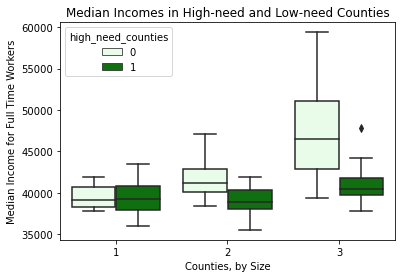

In [361]:
## Begin to test hypothesis and measure the needs of the county against median income 

## In this plot we can see that median income becomes more and more 
## correlated to public healthcare needs as populations grow in size. 
sns.boxplot(x="county_size", y="med_income_FT", hue="high_need_counties", color="green", data=df )
plt.title("Median Incomes in High-need and Low-need Counties")
plt.xlabel("Counties, by Size")
plt.ylabel("Median Income for Full Time Workers") 

## Counties with lower median incomes (for full time workers) are more likely to be high-needs in healthcare 

Text(0, 0.5, 'Population without full High School Education')

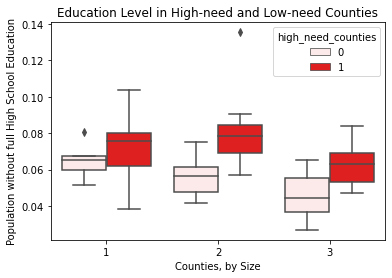

In [42]:
## Continue to test hypothesis and measure the needs of the county against educational attainment 

## In this plot we can see that there is a relationship between higher populations
## of people without high school education and a greater need for public healthcare
sns.boxplot(x="county_size", y="percentage_Grade_School", hue="high_need_counties", color="red", data=df )
plt.title("Education Level in High-need and Low-need Counties")
plt.xlabel("Counties, by Size")
plt.ylabel("Population without full High School Education") 

## High needs counties have higher rates of people who did not finish highschool

Text(0, 0.5, 'Percentage of Unemployment for Population over age 15')

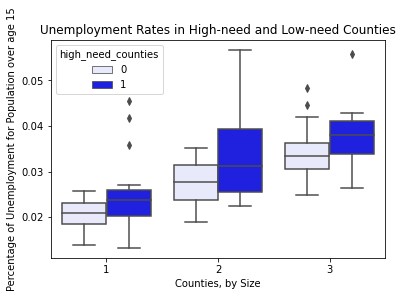

In [102]:
## In this plot we can see that there is a relationship unemployment rates and need for public healthcare

sns.boxplot(x="county_size", y="percentage_Unemployed", hue="high_need_counties", color="blue", data=df )
plt.title("Unemployment Rates in High-need and Low-need Counties")
plt.xlabel("Counties, by Size")
plt.ylabel("Percentage of Unemployment for Population over age 15") 

## the relationship is particularly stressed when noticing high unemployment outliers in the smallest counties 
## although, those outliers could have other explanations like employment being underreported in rural areas 

Text(0, 0.5, 'Percentage of population without private healthcare')

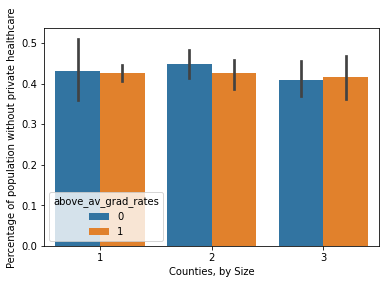

In [103]:
## this one does not strongly support the hypothesis as much as the other plots above 
## interestingly, this is defining "needs" using the target 2019 variable for the first time 

sns.barplot(x="county_size",y = "percentage_need_coverage", hue="above_av_grad_rates", data=df)
plt.xlabel("Counties, by Size")
plt.ylabel("Percentage of population without private healthcare") 

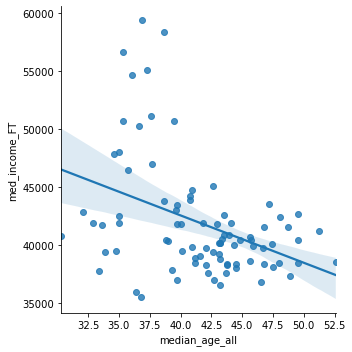

In [46]:
## this loosely correlates higher median income to lower median age
sns.lmplot(x="median_age_all", y="med_income_FT", data=df)

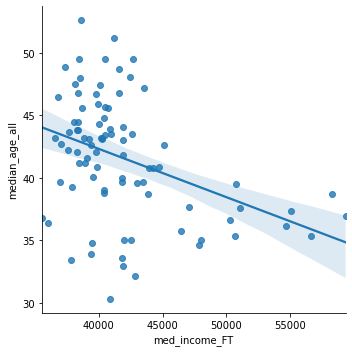

In [47]:
## flip the variables around to see the correlation more clearly  
sns.lmplot(x="med_income_FT", y="median_age_all", data=df)

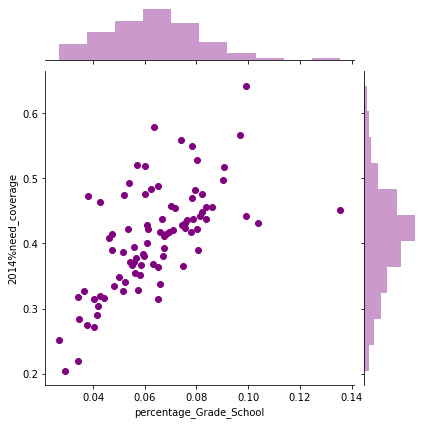

In [367]:
## this plot and the plot below indicate that educational attainment is somewhat correlated 
## to public healthcare needs, but largely within the same time frame, not as a future predictor 

sns.jointplot(x="percentage_Grade_School",y="2014%need_coverage",data=df, color="purple")

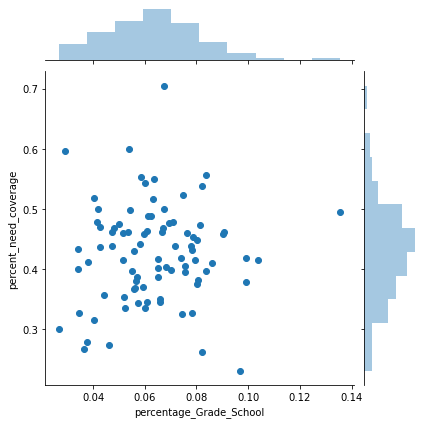

In [368]:
## this plot and the plot above indicate that educational attainment is somewhat correlated 
## to public healthcare needs, but largely within the same time frame, not as a future predictor 

sns.jointplot(x="percentage_Grade_School",y="percentage_need_coverage",data=df) ## dependent variable

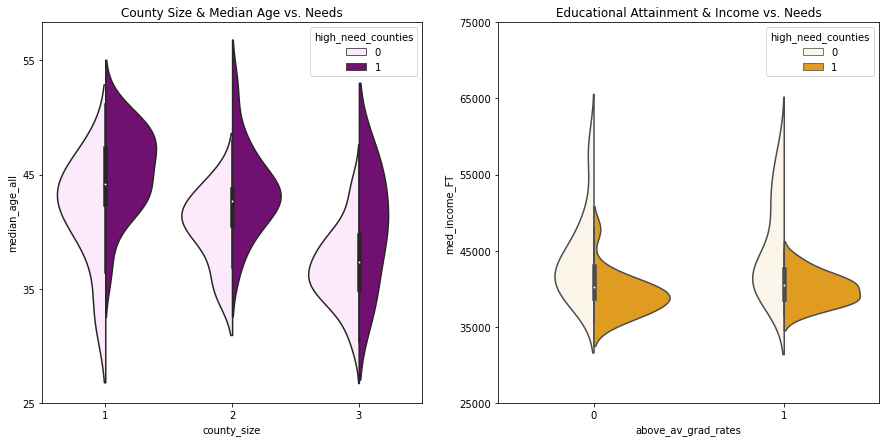

In [50]:
### violin plots
### was using plotly originally, but being interactive was not a necessary component 

f, ax = plt.subplots(1,2,figsize=(15,7))
sns.violinplot("county_size", "median_age_all", hue="high_need_counties", color="Purple", data= df, split=True, ax = ax[0]) 
ax[0].set_title("County Size & Median Age vs. Needs") 
ax[0].set_yticks(range(25,65,10)) 
sns.violinplot("above_av_grad_rates", "med_income_FT", hue="high_need_counties", color="Orange", data= df, split=True, ax = ax[1]) 
ax[1].set_title("Educational Attainment & Income vs. Needs")
ax[1].set_yticks(range(25000,80000,10000))

## in the first plot, we can see higher median age correlating to higher public healthcare needs
## in the second plot, we see graduation rates having little impact on median income for either

(array([ 1.02587346,  6.4971986 , 10.60069245,  5.47132514,  4.10349385,
         1.02587346,  0.68391564,  0.34195782]),
 array([0.28891724, 0.32253032, 0.35614339, 0.38975646, 0.42336953,
        0.4569826 , 0.49059568, 0.52420875, 0.55782182]),
 <a list of 8 Patch objects>)

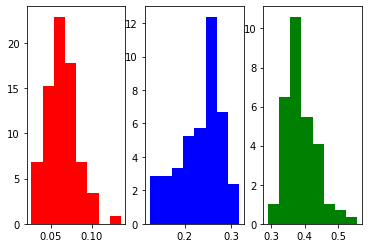

In [371]:
## quick histogram to explore the rates of education attainment throughout the State 
## these plots do not shed much light on the data because the scales of the plots differ 

plt.subplot(131)
plt.hist(df["percentage_Grade_School"], 8, density=1, facecolor='r')
plt.subplot(132)
plt.hist(df["percentage_HS_Diploma_GED"], 8, density=1, facecolor='b')
plt.subplot(133)
plt.hist(df["percentage_Higher_Ed"], 8, density=1, facecolor='g')

(array([ 1.02587346,  2.56468366,  7.69405097, 10.77167136,  9.7457979 ,
         3.59055712,  5.12936731,  1.02587346,  1.53881019,  1.02587346,
         0.        ,  0.51293673]),
 array([0.28891724, 0.31132596, 0.33373467, 0.35614339, 0.3785521 ,
        0.40096082, 0.42336953, 0.44577825, 0.46818696, 0.49059568,
        0.51300439, 0.53541311, 0.55782182]),
 <a list of 12 Patch objects>)

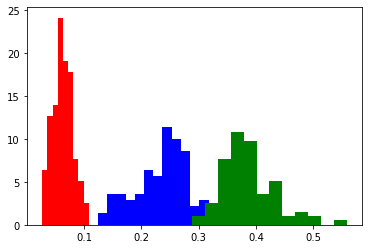

In [60]:
## originally, this was 3 separate adjacent plots, but the scales were different 
## the data is clearer if we put the histograms in overlapping plots 
## we can see that education attainment (highschool graduation and beyond) is high

plt.hist(df["percentage_Grade_School"], 12, density=1, facecolor='r')
plt.hist(df["percentage_HS_Diploma_GED"], 12, density=1, facecolor='b')
plt.hist(df["percentage_Higher_Ed"], 12, density=1, facecolor='g')


In [ ]:
## that went well

## NOW MOVING ON TO ADDING LINEAR REGRESSION MODELS

In [104]:
## multivariate linear regression model to predict `need_coverage` using all of the other variables
## this will establish the baseline usefullness of the variables
## original models from a previous project draft with less feature engineering were around 36%

X = df.iloc[:,4:] ## all columns and rows 4-end (exclude county name and dependent variable)
Y = df["need_coverage"] 
 
lr = linear_model.LinearRegression() 

model_0 = lr.fit(X, Y) 

## Calculating the R^2 of our model 
print("R^2 = " + str(model_0.score(X, Y))) 

R^2 = 0.5220283411598641


In [95]:
df.head()

,county_index,need_coverage,percentage_need_coverage,2019_high_need_counties,percentage_no_coverage,percentage_Employed,percentage_Unemployed,percentage_female,percentage_male,percentage_sixteen_yrs_plus,...,18-24years_w_pbcoverage,18-24years_no_pbcoverage,25-44years_w_pbcoverage,25-44years_no_pbcoverage,45-64years_w_pbcoverage,45-64years_no_pbcoverage,65+years_w_pbcoverage,65+years_no_pbcoverage,total_w_pbcoverage,total_no_pbcoverage
0,Aitkin County,9657,0.417961,0,0.081809,0.409108,0.036081,0.492420,0.507580,0.846279,...,224,576,623,1942,1330,3791,4432,51,7620,8150
1,Anoka County,23543,0.355715,0,0.073229,0.531173,0.041042,0.499869,0.500131,0.779383,...,4087,22931,12140,78000,12293,84246,34861,935,81594,252118
2,Becker County,1675,0.417186,0,0.115253,0.475205,0.022505,0.497862,0.502138,0.782294,...,627,1606,1374,5625,1859,7637,5664,81,12292,20292
3,Beltrami County,21273,0.335293,0,0.139955,0.449642,0.055730,0.499204,0.500796,0.776616,...,1339,5166,2752,7247,2354,8663,5758,132,17122,27610
4,Benton County,9013,0.430235,1,0.091739,0.505413,0.044510,0.500436,0.499564,0.776372,...,864,2675,2115,9087,1543,7985,4516,47,11795,26670


In [65]:
## multivariate linear regression model to predict `percentage_need_coverage` using all of the other variables
## this will establish the baseline usefullness of the variables and show that 
## the percentage of the population that need coverage is an easier variable to model and predict 
## original models from a previous project draft with less feature engineering were around 45%

X = df.iloc[:,4:] ## all columns and rows 4-end (exclude county name and dependent variable)
Y = df["percentage_need_coverage"] 

model_1 = lr.fit(X, Y) 

print("R^2 = " + str(model_1.score(X, Y))) 

R^2 = 0.661615558664994


In [570]:
## it appears as if the above feature engineering has increased model accuracy

In [77]:
## now lets use RFE to narrow down our variables 
X = df.drop(columns=['county_index', 'need_coverage', 'percentage_need_coverage','2019_high_need_counties'], axis = 1)
Y = df["percentage_need_coverage"]

rfe = RFE(lr, n_features_to_select=10)
model_RFE = rfe.fit(X,Y)

## still can't figure out why this RFE includes excluded variables, tried several different ways 

print("Ideal features for target variable prediction:")
print(sorted(zip(map(lambda X: round(X, 4), rfe.ranking_), df.columns)))

In [76]:
## using the 20 best variables from the RFE

X = df[[
'0-17years_no_pbcoverage',
'18-24years_no_pbcoverage',
'2014_need_coverage',
'25-44years_no_pbcoverage',
'percentage_Employed',
'percentage_Grade_School',
'percentage_HS_and_Higher',
'percentage_Higher_Ed',
'percentage_Unemployed',
'percentage_female',
'percentage_fortyfive_to_sixtyfour_yrs',
'percentage_households_not_receiving_benefits',
'percentage_male',
'percentage_no_coverage',
'percentage_sixteen_yrs_plus',
'percentage_sixtyfive_yrs_plus',
'percentage_twentyfive_to_fortyfour_yrs',
'percentage_w_pbcoverage',
'total_pop',
'total_pop_male'
]]

X = sm.add_constant(X) # Adding a constant
Y = df["percentage_need_coverage"] 

model_2 = lr.fit(X, Y) 
print("R^2 = " + str(model_2.score(X, Y))) 


R^2 = 0.19369382645120226


In [81]:
## expanding variables a bit further with another RFE for 50 variables 

X = df[[
'0-17years_no_pbcoverage',
'0-17years_no_pvcoverage',
'0-17years_w_coverage',
'0-17years_w_pvcoverage',
'18-24years_no_pbcoverage',
'18-24years_no_pvcoverage',
'18-24years_w_coverage',
'18-24years_w_pvcoverage',
'2014_need_coverage',
'25-44years_no_pbcoverage',
'45-64years_no_coverage',
'45-64years_no_pbcoverage',
'45-64years_no_pvcoverage',
'45-64years_w_coverage',
'45-64years_w_pvcoverage',
'65+years_no_coverage',
'65+years_w_pvcoverage',
'Employed',
'Not_in_Labor_Force',
'Unemployed',
'above_av_grad_rates',
'county_size', 
'fortyfive_to_sixtyfour_yrs',
'high_need_counties',
'median_age_all',
'median_age_female',
'median_age_male',
'percentage_Employed',
'percentage_Grade_School',
'percentage_HS_Diploma_GED',
'percentage_HS_and_Higher',
'percentage_Higher_Ed',
'percentage_Unemployed',
'percentage_female',
'percentage_fortyfive_to_sixtyfour_yrs',
'percentage_households_not_receiving_benefits',
'percentage_male',
'percentage_no_coverage',
'percentage_sixteen_yrs_plus',
'percentage_sixtyfive_yrs_plus',
'percentage_twentyfive_to_fortyfour_yrs',
'percentage_w_pbcoverage',
'total_households',
'total_no_pvcoverage',
'total_pop',
'total_pop_female',
'total_pop_male',
'total_w_coverage',
'total_w_pvcoverage',
'twentyfive_to_fortyfour_yrs']]

X = sm.add_constant(X) # Adding a constant
Y = df["percentage_need_coverage"] 
lr = linear_model.LinearRegression() 
model_3 = lr.fit(X, Y) 
print("R^2 = " + str(model_3.score(X, Y))) 

R^2 = 0.5044763593662964


In [382]:
## pause here, narrow down ideal variables after mentor meeting 

## TAKE A SWING AT A LOGISTIC REGRESSION 

In [385]:
## let's run another RFE but to predict "high_need_counties"

X = df.iloc[:,4:]
Y = df["2019_high_need_counties"]

rfe = RFE(lr, n_features_to_select=13)
model_RFE2 = rfe.fit(X,Y)

print("Ideal features for target variable prediction:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), df.columns)))

In [386]:
print("Ideal features for target variable prediction:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), df.columns)))

Ideal features for target variable prediction:
[(1, '2019_high_need_counties'), (1, 'county_index'), (1, 'need_coverage'), (1, 'percent_need_coverage'), (1, 'percentage_Employed'), (1, 'percentage_HS_and_Higher'), (1, 'percentage_Higher_Ed'), (1, 'percentage_female'), (1, 'percentage_male'), (1, 'percentage_no_coverage'), (1, 'percentage_sixteen_yrs_plus'), (1, 'percentage_sixtyfive_yrs_plus'), (1, 'percentage_twentyfive_to_fortyfour_yrs'), (2, 'percentage_fortyfive_to_sixtyfour_yrs'), (3, 'percentage_HS_Diploma_GED'), (4, 'percentage_households_not_receiving_benefits'), (5, 'percentage_w_pbcoverage'), (6, 'percentage_Unemployed'), (7, 'total_pop_male'), (8, 'percentage_Grade_School'), (9, '2014_need_coverage'), (10, 'total_pop'), (11, 'total_no_coverage'), (12, 'median_age_all'), (13, 'total_w_coverage'), (14, '0-17years_no_pbcoverage'), (15, 'median_age_male'), (16, '18-24years_w_pbcoverage'), (17, '18-24years_no_pbcoverage'), (18, 'median_age_female'), (19, '0-17years_w_pbcoverage')

In [387]:
## with these variables accuracy is 39%, [[0,11],[0,7]] with all counties predicted to be high-need, test_size=0.2
'percentage_Employed', 'percentage_HS_and_Higher', 'percentage_Higher_Ed', 'percentage_female',
'percentage_male','percentage_no_coverage','percentage_sixteen_yrs_plus',
'percentage_sixtyfive_yrs_plus', 'percentage_twentyfive_to_fortyfour_yrs'
## reducing test_size to .1 from .2 to hopefully increase effectiveness of the model 
## accuracy increased to 56% using a larger training set of data 

('percentage_sixtyfive_yrs_plus', 'percentage_twentyfive_to_fortyfour_yrs')

In [388]:
## with these variables accuracy is 44%, [[2,9],[1,6]] with ten counties still classed incorrectly, test_size=0.2
'percentage_no_coverage','percentage_Employed','percentage_Unemployed', 
'percentage_female','percentage_male','percentage_sixteen_yrs_plus',
'percentage_twentyfive_to_fortyfour_yrs','percentage_fortyfive_to_sixtyfour_yrs',
'percentage_sixtyfive_yrs_plus','percentage_w_pbcoverage',
'percentage_households_not_receiving_benefits','percentage_Grade_School', 
'percentage_HS_Diploma_GED','percentage_Higher_Ed','percentage_HS_and_Higher', 
'county_size','above_av_grad_rates','high_need_counties','2014%need_coverage', 
'2014_need_coverage'
## reducing test_size to .1 from .2 to hopefully increase effectiveness of the model 
## accuracy increased to 56% using a larger training set of data 

'2014_need_coverage'

In [389]:
## most accurate and variable efficient model 
## 56% accuracy at test_size=0.1  [[2,3],[2,2]]
'percentage_no_coverage','percentage_w_pbcoverage',
'percentage_HS_Diploma_GED','percentage_Grade_School',
'above_av_grad_rates','median_age_all','2014%need_coverage',
'percentage_Employed','percentage_Unemployed'
## 33% accuracy at test_size=0.2 [[0,11],[1,6]]

('percentage_Employed', 'percentage_Unemployed')

In [105]:
### Logistic regression with sklearn 
## most accurate and variable efficient model 
## 56% accuracy at test_size=0.1  [[2,3],[2,2]]

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report 

X = df[['percentage_no_coverage','percentage_w_pbcoverage',
'percentage_HS_Diploma_GED','percentage_Grade_School',
'above_av_grad_rates','median_age_all','2014%need_coverage',
'percentage_Employed','percentage_Unemployed']]

y = df["2019_high_need_counties"] 

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=87)

In [110]:
logmodel = LogisticRegression(solver="liblinear") 
logmodel.fit(X_train,y_train) 

LogisticRegression(solver='liblinear')

In [111]:
predictions = logmodel.predict(X_test) 

In [112]:
print(classification_report(y_test,predictions)) 

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.60      0.60      0.60         5

    accuracy                           0.56         9
   macro avg       0.55      0.55      0.55         9
weighted avg       0.56      0.56      0.56         9



[[2 2]
 [2 3]]


[Text(0, 0.5, 'Low-need'), Text(0, 1.5, 'High-need')]

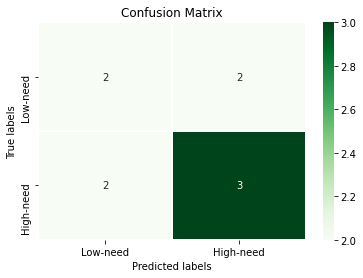

In [89]:
from sklearn.metrics import confusion_matrix

cmatrix = confusion_matrix(y_test, predictions)
print(cmatrix)

ax= plt.subplot()
sns.heatmap(cmatrix, annot=True, ax = ax, linewidths=1, cmap="Greens"); # Use `annot=True` to annotate cells

# Set labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Low-need', 'High-need']); ax.yaxis.set_ticklabels(['Low-need', 'High-need'])

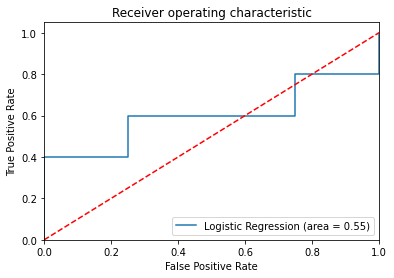

In [90]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = {})'.format(logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()